# Klasyfikacja

# Autorzy

Adam Dohojda, Kacper Kiereś, Dawid Koceniak, Wiktoria Stęczna

# Wstępne analiza danych

##### Import bibliotek

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy.stats import skew, kurtosis

##### Wczytywanie danych

In [27]:
df = pd.read_excel('rice.xlsx').set_index('Class')

##### Obsługa braków danych

In [28]:
np.sum(np.isnan(df), axis=0)

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
dtype: int64

Stwierdzamy brak pustych wartości

##### Wizualizacja zmiennych, wraz z ich szacowanymi gęstościami

W tym kroku zwizualizujemy wszystkie zmienne, chcąc otrzymać histogramy gęstości (tak więc oś pionowa przedstawia częstości, zamiast liczby występujących wartości zmiennej). Dodatkowo w celu pogłębionego zrozumienia skorzystaliśmy z metody [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) z pakietu SeaBorn w celu nakreślenia estymowanej krzywej gęstości. Więcej o zaimplementowanej metodzie można poczytać [tutaj](https://en.wikipedia.org/wiki/Kernel_density_estimation).

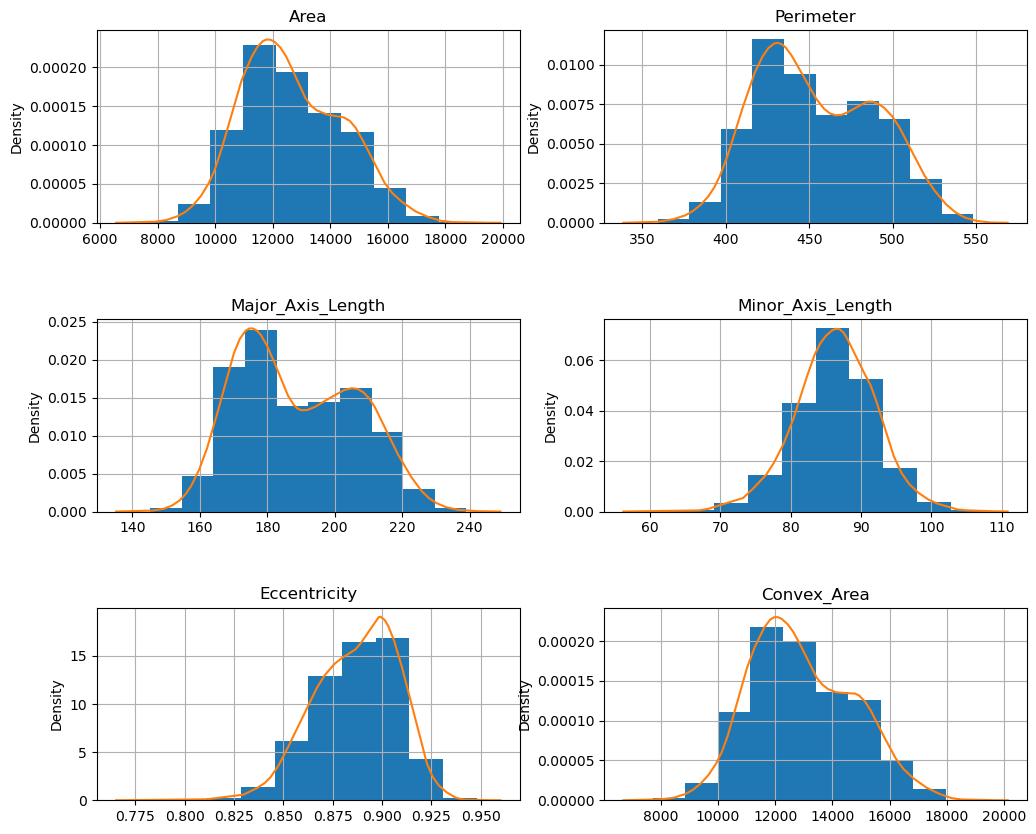

In [29]:
plt.style.use('fast')
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
for ax, col in zip(axs.flat, df.columns):
    ax.hist(df[col], bins=10, density=True)
    sns.kdeplot(df[col], ax=ax)
    ax.grid(True)
    ax.set_title(col)
    ax.set_xlabel('')

##### Statystyki opisowe

W tej części policzymy i zinterpretujemy statystyki opisowe naszego zbioru danych. Do podstawowych statystyk liczonych przez pakiet Pandas dodaliśmy obliczoną [skośność](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html#scipy.stats.skew) i [kurtozę](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html).

In [30]:
skewnesses = skew(df, axis=0)
kurtosises = kurtosis(df, axis=0)
stats = pd.concat([df.describe(), pd.DataFrame({'skewness':skewnesses, 'kurtosis':kurtosises}, index=df.columns).T]).T
stats['coef_of_var'] = stats['std'] / stats['mean']
stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,coef_of_var
Area,3810.0,12667.727559,1732.367706,7551.000000,11370.500000,12421.500000,13950.000000,18913.000000,0.325030,-0.432091,0.136754
Perimeter,3810.0,454.239180,35.597081,359.100006,426.144752,448.852493,483.683746,548.445984,0.221275,-0.840715,0.078366
Major_Axis_Length,3810.0,188.776222,17.448679,145.264465,174.353855,185.810059,203.550438,239.010498,0.260140,-0.952128,0.092430
Minor_Axis_Length,3810.0,86.313750,5.729817,59.532406,82.731695,86.434647,90.143677,107.542450,-0.134844,0.559801,0.066384
Eccentricity,3810.0,0.886871,0.020818,0.777233,0.872402,0.889050,0.902588,0.948007,-0.449072,0.069405,0.023473
Convex_Area,3810.0,12952.496850,1776.972042,7723.000000,11626.250000,12706.500000,14284.000000,19099.000000,0.319656,-0.466788,0.137191
Extent,3810.0,0.661934,0.077239,0.497413,0.598862,0.645361,0.726562,0.861050,0.343684,-1.030324,0.116687


# Modele klasyfikacyjne

## Przygotowywanie danych do przeprowadzenia klasyfikacji

##### Załadowanie danych

In [31]:
df = pd.read_excel('rice.xlsx', header=None)
X = df.loc[1:, :6].values
y = df.loc[1:, 7].values

Używając obiektu LabelEncoder, przekształcamy etykiety klas na liczby całkowite

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Class labels: ", le.classes_)

Class labels:  ['Cammeo' 'Osmancik']


In [33]:
le.transform(['Cammeo', 'Osmancik'])

array([0, 1])

Dzielenie zbioru danych na próbę treningową (80% danych) i próbę testową (20% danych).

In [34]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, 
                     stratify = y,
                     random_state = 0)

In [35]:
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y:  [1630 2180]
Labels counts in y_train:  [1304 1744]
Labels counts in y_test:  [326 436]


##### Standaryzacja zmiennych

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Implementacja funkcji do wizualizacji granic decyzyjnych dwuwymiarowych danych

In [37]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<', '>', 'D', 'P', 'X', '*')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'purple', 'pink', 'yellow', 'black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


Funkcja  rysuje obszar decyzyjny na podstawie danych treningowych i klasyfikatora, a także wyświetla przykłady klas.

Definiujemy liczbę kolorów i znaczników oraz tworzymy mapę kolorów z listy kolorów za pomocą `ListedColormap`.

Tworzymy siatkę punktów `xx1` i `xx2` na podstawie minimalnych i maksymalnych wartości cech, a następnie przewidujemy klasy dla każdego punktu na siatce za pomocą modelu klasyfikatora `classifier.predict`. Wynikowy konturowy wykres przedstawia obszar decyzyjny, gdzie różne kolory odpowiadają różnym klasom, a punkty treningowe są również wyświetlane na wykresie, reprezentując różne klasy.

Dodatkowo, używając różnych markerów `markers` i kolorów `colors`, funkcja oznacza punkty dla różnych klas na wykresie, co pozwala wizualnie rozróżnić klasy.

`plot_decision_regions` będzie przez nas wykorzystywany, kiedy wyłonimy w dalszej części projektu modele, o jak najlepszej dokładności dopasowania do danych.

## PCA

Inicjalizacja tranformatora PCA i estymatora regresji logistycznej

In [38]:
pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')

Redukcja wymiarów

In [39]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Dopasowywanie modelu regresji logistycznej do zredukowanego zbioru danych

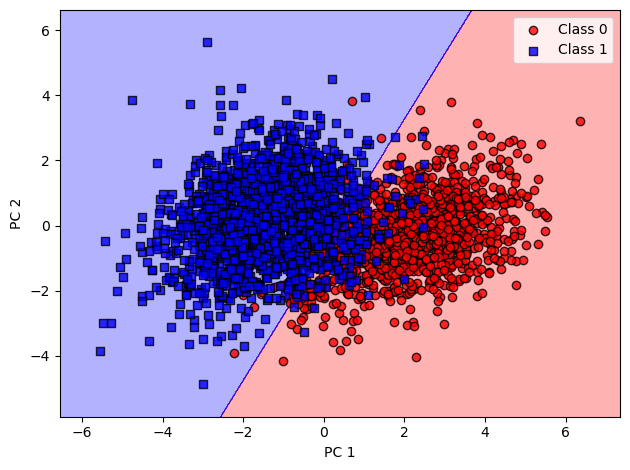

In [40]:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

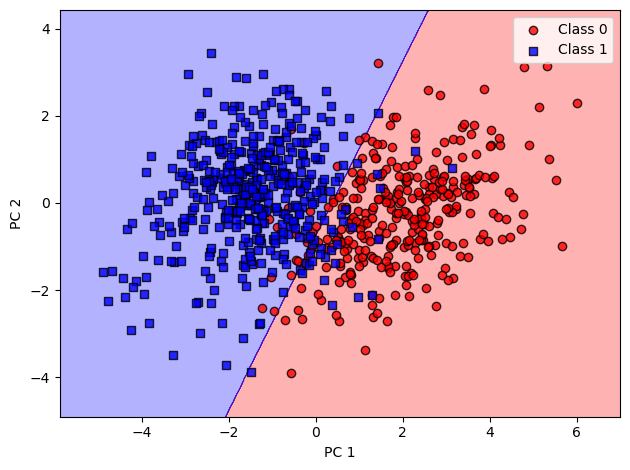

In [41]:
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Analiza wskaźników oceny wydajności

#### Łączenie transformatorów i estymatorów w potoku
Normalizujemy kolumny w zbiorze danych za pomocą `StandardScaler`, kompresujemy dane do dwuwymiarowej podprzestrzeni za pomocą `PCA`. a następnie przekazujemy je do klasyfikatora regresji logistycznej `LogisticRegression`, za pomocą funkcji `make_pipeline`.

In [60]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc: .3f}')

Test accuracy:  0.923


Funkcja `make_pipeline` pobiera dowolną liczbę transformatorów scikit-learn, a następnie estymator scikit-learn, który implementuje metody `fit` oraz `predict`.

W powyższym zapisie, dostarczyliśmy dwa transformatory scikit-learn - `StandardScaler` i `PCA` oraz estymator `LogisticRegression` jako dane wejściowe do funkcji `make_pipeline`, która konstruuje obiekt scikit-learn `Pipeline` z tych obiektów.

Na końcu zwracamy prognozę na podstawie przekształconych danych.


#### Macierz pomyłek

In [62]:
from sklearn.metrics import confusion_matrix
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[300  26]
 [ 33 403]]


#### Krzywa ROC

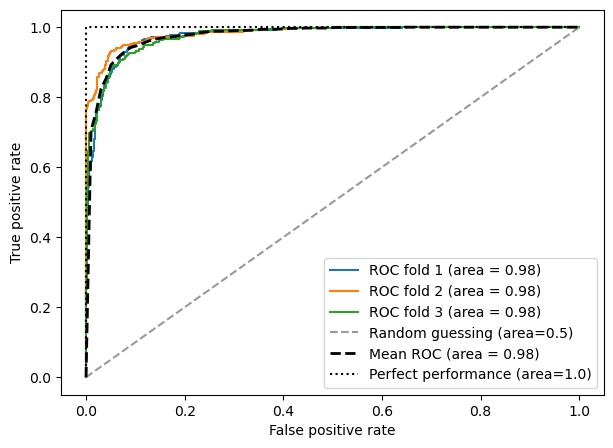

In [63]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components = 2),
    LogisticRegression(penalty = 'l2', random_state = 1,
                       solver = 'lbfgs', C = 100.0)
)
X_train2 = X_train[:, [1, 2]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
     probas = pipe_lr.fit(
          X_train2[train],
          y_train[train]).predict_proba(X_train2[test])
     fpr, tpr, thresholds = roc_curve(y_train[test],
                                      probas[:, 1],
                                      pos_label=1)
     mean_tpr += interp(mean_fpr, fpr, tpr)
     mean_tpr[0] = 0.0
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr,
              tpr,
              label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

## SVM

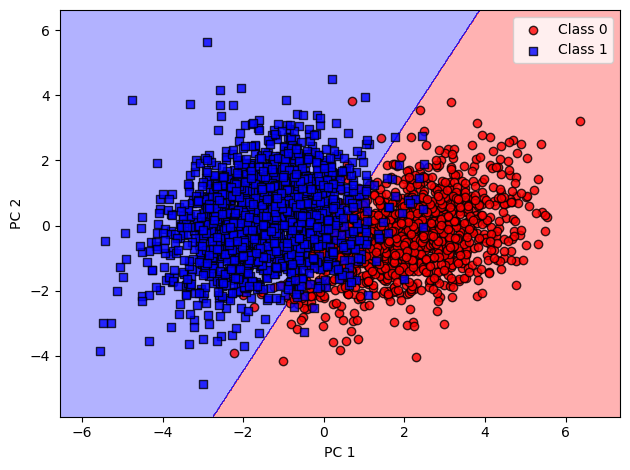

In [64]:
from sklearn.svm import SVC

# Tworzenie obiektu SVM
svm = SVC(kernel='linear', C=10.0, random_state=1)

# Dopasowanie modelu SVM do danych z PCA
svm.fit(X_train_pca, y_train)

# Wizualizacja wyników na zbiorze treningowym po PCA
plot_decision_regions(X_train_pca, y_train, classifier=svm)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

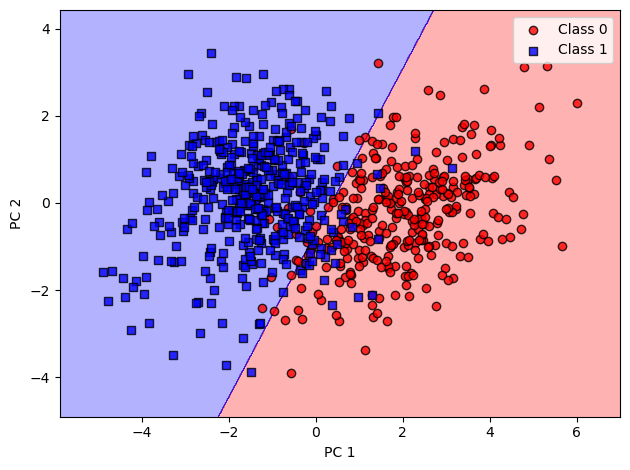

In [65]:
# Wizualizacja wyników na zbiorze testowym po PCA
plot_decision_regions(X_test_pca, y_test, classifier=svm)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analiza wskaźników oceny wydajności

#### Łączenie transformatorów i estymatorów w potoku
Normalizujemy kolumny w zbiorze danych za pomocą `StandardScaler`, kompresujemy dane do dwuwymiarowej podprzestrzeni za pomocą `PCA`. a następnie przekazujemy je do klasyfikatora regresji logistycznej `LogisticRegression`, za pomocą funkcji `make_pipeline`.

In [66]:
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(kernel = 'linear',
                            C = 10.0,
                            random_state=1))
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
test_acc = pipe_svc.score(X_test, y_test)
print(f'Test accuracy: {test_acc: .3f}')

Test accuracy:  0.920


Funkcja `make_pipeline` pobiera dowolną liczbę transformatorów scikit-learn, a następnie estymator scikit-learn, który implementuje metody `fit` oraz `predict`.

W powyższym zapisie, dostarczyliśmy transformator scikit-learn - `StandardScaler` oraz estymator `SVC` jako dane wejściowe do funkcji `make_pipeline`, która konstruuje obiekt scikit-learn `Pipeline` z tych obiektów.

Na końcu zwracamy prognozę na podstawie przekształconych danych.


#### Macierz pomyłek

In [67]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[297  29]
 [ 32 404]]


#### Optymalizacja dokładności (precision) i wycofania (recall) modelu klasyfikacji

In [68]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val}')

rec_val = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val}')

f1_val = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val}')

mcc_val = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.9330254041570438
Recall: 0.926605504587156
F1: 0.9298043728423475
MCC: 0.837


#### Krzywa ROC


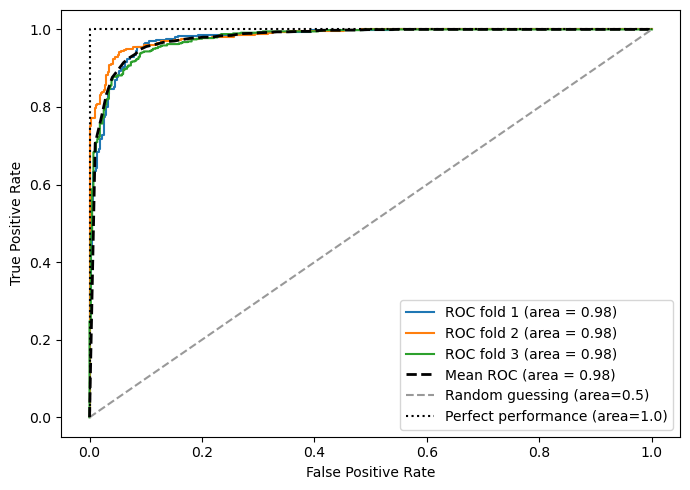

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie potoku z użyciem SVC i StandardScaler
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C = 10.0, probability=True, random_state=1))

# Podział danych do walidacji krzyżowej
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Inicjalizacja wykresu
fig = plt.figure(figsize=(7, 5))

mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Dla każdego podziału walidacji krzyżowej
for i, (train, test) in enumerate(cv):
    # Dopasowanie modelu do danych treningowych
    probas = pipe_svc.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Obliczenie współczynników True Positive Rate (TPR) oraz False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolacja wyników na średnią krzywą ROC
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Obliczenie pola pod krzywą ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Wyświetlenie krzywej ROC dla każdego podziału
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Obliczenie średniego True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Obliczenie średniego pola pod krzywą ROC (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Wyświetlenie średniej krzywej ROC
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Wyświetlenie linii referencyjnych
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Ustawienia osi i legendy
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
